# How to use `for` to run node in parallel

## Introduction
In this tutorial, you will learn how to run node in parallel.

Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='4a9501fb20364cecb99920cadf27b238' name='xing'>

## First workflow: for
Suppose we want to calculate ```(x + y) * z ``` in two steps. First, add `x` and `y`, then multiply the result with `z`. And `X` is a list of values. We want to calculate tihs in parallel.


### Create node
First, one shoud know that we can not lanuch subprocess inside a `node` or a `calcfunction`. We need a create a `WorkTree` to run node in parallel. And then treat this `WorkTree` as a node.

In [2]:
from aiida_worktree import node, WorkTree
from aiida.engine import calcfunction
from aiida.orm import List

# define add node
@node()
@calcfunction
def add(X, y):
    Z = []
    for x in X:
        z = x+y
        z.store()
        Z.append(z.uuid)
    return List(Z)

# define multiply node
@node()
@calcfunction
def multiply(x, y):
    return x*y

# Create a WorkTree as a node
@node.group()
def multiply_for(uuids, y):
    from aiida.orm import load_node
    wt = WorkTree("multiply_for")
    # here the node `multiply` is created and will run in parallel
    for uuid in uuids:
        x = load_node(uuid)
        wt.nodes.new(multiply, x=x, y=y)
    # don't forget to return the wt
    return wt

### Create the workflow


In [3]:
from aiida_worktree import WorkTree
from aiida.orm import Int, List

X = List([1, 2, 3])
y = Int(2)
z = Int(3)
wt = WorkTree("parallel_node")
add1 = wt.nodes.new(add, name="add1", X=X, y=y)
multiply_for1 = wt.nodes.new(multiply_for, name="multiply_for1", y=z)
wt.links.new(add1.outputs[0], multiply_for1.inputs["uuids"])

wt.submit(wait=True)

[INFO] 2023-07-29 14:25:06 nodetree: Create NodeTree: parallel_node


### Check status and results


In [4]:
print("State of WorkTree:   {}".format(wt.state))
print('Result of add      : {}'.format(wt.nodes["add1"].node.outputs.result.get_list()))

State of WorkTree:   FINISHED
Result of add      : ['8210ca86-0993-449a-af8f-12b0033c2689', 'b8aa7e98-c1ac-4100-b158-d5fbfc738a5e', '9350e27f-ce74-4a58-9b8d-7a10108e8de7']


Generate node graph from the AiiDA process:

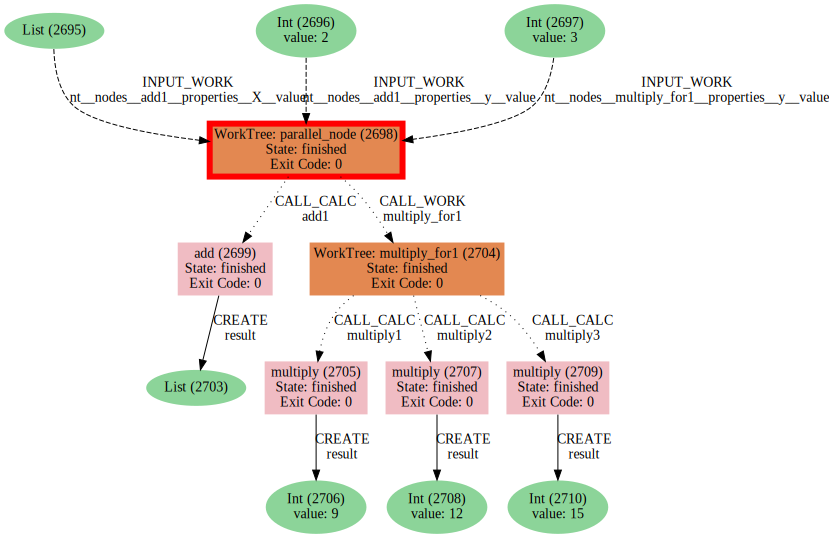

In [5]:
from aiida_worktree.utils import generate_node_graph
generate_node_graph(wt.pk)

## Second workflow: gather results
Now I want to gather the results from the previous `multiply_for` nodes and calculate the sum of all their results.
Let's update the `multiply_for` function to `multiply_for_gather`. The `AiiDAGather` node will be used.

In [6]:
@node.group(outputs = [["gather1", "result", "result"]])
def multiply_for_gather(uuids, y):
    from aiida.orm import load_node
    nt = WorkTree("multiply")
    nt.nodes.new("AiiDAGather", name="gather1")
    for uuid in uuids:
        x = load_node(uuid)
        multiply1 = nt.nodes.new(multiply, x=x, y=y)
        nt.links.new(multiply1.outputs[0], nt.nodes["gather1"].inputs[0])
    return nt

@node()
@calcfunction
def sum(uuids):
    from aiida.orm import Float, load_node
    total = 0
    for uuid in uuids:
        total += load_node(uuid).value
    return Float(total)

Now, let's create a `WorkTree` to use the new node:

In [7]:
from aiida_worktree import WorkTree
from aiida.orm import Int, List

X = List([1, 2, 3])
y = Int(2)
z = Int(3)
wt = WorkTree("parallel_node")
add1 = wt.nodes.new(add, name="add1", X=X, y=y)
multiply_for_gather1 = wt.nodes.new(multiply_for_gather, name="multiply_for_gather1", y=z)
sum1 = wt.nodes.new(sum, name="sum1")
wt.links.new(add1.outputs[0], multiply_for_gather1.inputs["uuids"])
wt.links.new(multiply_for_gather1.outputs[0], sum1.inputs[0])

wt.submit(wait=True)

[INFO] 2023-07-29 14:25:17 nodetree: Create NodeTree: parallel_node


Get the result of the nodes:

In [8]:
print("State of WorkTree:   {}".format(wt.state))
print('Result of node add1: {}'.format(wt.nodes["sum1"].node.outputs.result.value))

State of WorkTree:   FINISHED
Result of node add1: 36.0


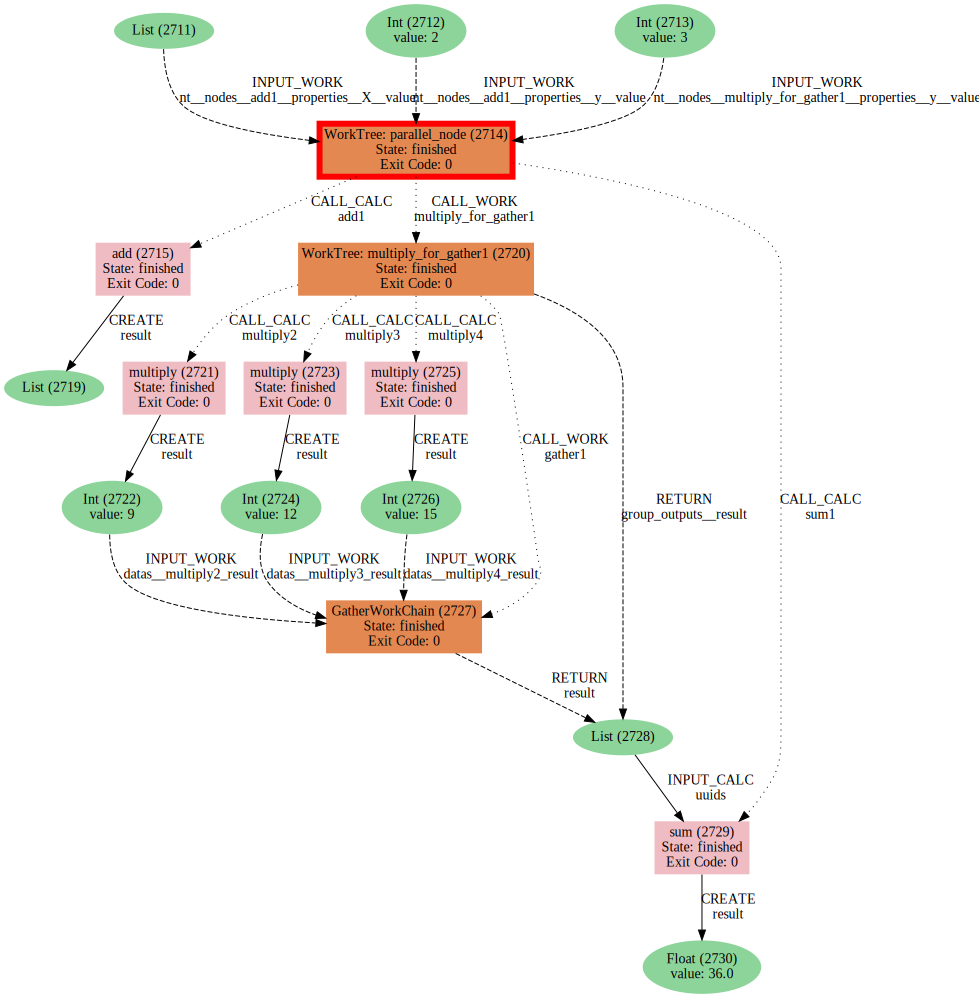

In [9]:
from aiida_worktree.utils import generate_node_graph
generate_node_graph(wt.pk)

You may notice that, in the node graph the result (a list of uuids) of the `add` node is not pass as the input of the `WorkTree:multiply_for_gather1` . Because the function `multiply_for_gather` is not a `calcfunction`. It is a normal function, which uses list of uuids to constructure a `Worktree`. And this `Worktree` is dynamic and based on the result of the `add` node.